In [19]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder

In [20]:
# Load dataset
file_path = 'nutri_score_results.csv'  # Ganti dengan path file Anda
dataset = pd.read_csv(file_path)

# Tentukan kolom target
target_column = 'nutri_score'
X = dataset.drop(columns=[target_column])  # Fitur
y = dataset[target_column]  # Target

# Pisahkan data menjadi 80% training dan 20% testing
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Gabungkan kembali hasil split menjadi dua DataFrames untuk penyimpanan
train_data = pd.concat([X_train_raw, y_train], axis=1)
test_data = pd.concat([X_test_raw, y_test], axis=1)

# Simpan data latih dan data uji ke file CSV
train_file_path = 'train_data.csv'
test_file_path = 'test_data.csv'
train_data.to_csv(train_file_path, index=False)
test_data.to_csv(test_file_path, index=False)

print(f"Data latih disimpan di: {train_file_path}")
print(f"Data uji disimpan di: {test_file_path}")

Data latih disimpan di: train_data.csv
Data uji disimpan di: test_data.csv


In [21]:
# Preprocessing function
def preprocess_product_name(df):
    # Extract brand (first word before underscore or space)
    df['brand'] = df['nama_produk'].apply(lambda x: re.split(r'[_ ]', x)[0].lower())
    # Extract product type (remaining meaningful words without numbers and special characters)
    df['product_type'] = df['nama_produk'].apply(
        lambda x: ' '.join(
            [word.lower() for word in re.findall(r'[a-zA-Z]+', x) if len(word) > 2]
        )
    )
    return df

# Preprocess train and test data
train_data_processed = preprocess_product_name(train_data.copy())
test_data_processed = preprocess_product_name(test_data.copy())

# One-hot encoding for 'brand' column
one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
train_brand_encoded = one_hot_encoder.fit_transform(train_data_processed[['brand']])
test_brand_encoded = one_hot_encoder.transform(test_data_processed[['brand']])

# Convert the encoded arrays to DataFrames
train_brand_df = pd.DataFrame(train_brand_encoded, columns=one_hot_encoder.get_feature_names_out(['brand']))
test_brand_df = pd.DataFrame(test_brand_encoded, columns=one_hot_encoder.get_feature_names_out(['brand']))

# Combine encoded features with the datasets
train_data_processed = pd.concat([train_data_processed.reset_index(drop=True), train_brand_df], axis=1)
test_data_processed = pd.concat([test_data_processed.reset_index(drop=True), test_brand_df], axis=1)

# Ensure consistent features between train and test
missing_cols = set(train_data_processed.columns) - set(test_data_processed.columns)
for col in missing_cols:
    test_data_processed[col] = 0  # Add missing columns in test set with 0
test_data_processed = test_data_processed[train_data_processed.columns]  # Align column order

# Drop unnecessary columns
train_features = train_data_processed.drop(['nama_produk', 'brand', 'product_type', 'category'], axis=1, errors='ignore')
test_features = test_data_processed.drop(['nama_produk', 'brand', 'product_type', 'category'], axis=1, errors='ignore')

# Train-validation split
X = train_features.drop('nutri_score', axis=1)  # Features
y = train_features['nutri_score']  # Target
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
# Train RandomForestRegressor
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate model
y_pred = rf_model.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
print(f'Mean Squared Error (Validation): {mse}')

Mean Squared Error (Validation): 0.523377634439287


In [23]:
# Predict on test data
test_predictions = rf_model.predict(test_features.drop('nutri_score', axis=1, errors='ignore'))
output = pd.DataFrame({
    'nama_produk': test_data_processed['nama_produk'],
    'predicted_nutri_score': test_predictions
})
print(output.head())

                                  nama_produk  predicted_nutri_score
0  Cedea_FrozenFood_PremiumSalmonSausage_390G               1.310088
1      Cedea_FrozenFood_KoreanOdengSpicy_480G               4.698533
2  SoGood_FrozenFood_ChickenStickPremium_400G               2.713838
3     Lotte_Biscuit_ChocoPieMarsmallow2'S_52G               4.241172
4           Guribee_Snack_SnackRumputLaut_65G               7.930078


In [48]:
output = pd.DataFrame({
    'nama_produk': test_data_processed['nama_produk'],
    'product_type': test_data_processed['product_type'],  # Opsional
    'category': test_data_processed['category'],          # Opsional
    'predicted_nutri_score': test_predictions
})

print(output.head())

                                  nama_produk  \
0  Cedea_FrozenFood_PremiumSalmonSausage_390G   
1      Cedea_FrozenFood_KoreanOdengSpicy_480G   
2  SoGood_FrozenFood_ChickenStickPremium_400G   
3     Lotte_Biscuit_ChocoPieMarsmallow2'S_52G   
4           Guribee_Snack_SnackRumputLaut_65G   

                            product_type category  predicted_nutri_score  
0  cedea frozenfood premiumsalmonsausage        C               1.310088  
1      cedea frozenfood koreanodengspicy        C               4.698533  
2  sogood frozenfood chickenstickpremium        C               2.713838  
3       lotte biscuit chocopiemarsmallow        C               4.241172  
4          guribee snack snackrumputlaut        C               7.930078  


In [24]:
# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}
grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error'
)
grid_search.fit(X_train, y_train)

# Print best parameters and score
best_params = grid_search.best_params_
best_mse = -grid_search.best_score_
print("Best Hyperparameters:", best_params)
print("Best MSE (Grid Search):", best_mse)

Fitting 3 folds for each of 216 candidates, totalling 648 fits
Best Hyperparameters: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best MSE (Grid Search): 1.401756205206774


In [25]:
# Train the final model with best hyperparameters
best_rf_model = RandomForestRegressor(**best_params, random_state=42)
best_rf_model.fit(X_train, y_train)

# Evaluate final model on test set
final_test_predictions = best_rf_model.predict(test_features.drop('nutri_score', axis=1, errors='ignore'))
final_mse_test = mean_squared_error(y_test, final_test_predictions)
print(f"Final Test MSE: {final_mse_test}")

Final Test MSE: 1.8422495813228175


In [26]:
import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Define the objective function for Bayesian Optimization
def objective(trial):
    # Suggest values for hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 100, 500)
    max_depth = trial.suggest_categorical('max_depth', [10, 20, 30, None])
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])

    # Initialize Random Forest model with suggested hyperparameters
    rf_model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42
    )
    
    # Fit the model on training data
    rf_model.fit(X_train, y_train)
    
    # Predict on validation data
    y_pred_val = rf_model.predict(X_val)
    
    # Calculate MSE
    mse = mean_squared_error(y_val, y_pred_val)
    return mse

# Create an Optuna study
study = optuna.create_study(direction='minimize')  # Minimize MSE
study.optimize(objective, n_trials=50, n_jobs=-1)  # Perform optimization

# Print best hyperparameters and MSE
print("Best Hyperparameters:", study.best_params)
print("Best Validation MSE:", study.best_value)

# Train final model with best hyperparameters
best_rf_model = RandomForestRegressor(**study.best_params, random_state=42)
best_rf_model.fit(X_train, y_train)

# Evaluate final model on test data
final_test_predictions = best_rf_model.predict(test_features.drop('nutri_score', axis=1, errors='ignore'))
final_test_mse = mean_squared_error(y_test, final_test_predictions)
print(f"Final Test MSE (Bayesian Optimization): {final_test_mse}")


[I 2024-12-18 20:35:35,516] A new study created in memory with name: no-name-3b205dae-ce5a-41c3-a867-d93c6e35fb8e
[I 2024-12-18 20:35:38,506] Trial 4 finished with value: 10.455087140265453 and parameters: {'n_estimators': 121, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 4 with value: 10.455087140265453.
[I 2024-12-18 20:35:39,226] Trial 2 finished with value: 6.568046467137301 and parameters: {'n_estimators': 162, 'max_depth': 30, 'min_samples_split': 15, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 2 with value: 6.568046467137301.
[I 2024-12-18 20:35:39,317] Trial 1 finished with value: 18.554780591346233 and parameters: {'n_estimators': 224, 'max_depth': 10, 'min_samples_split': 17, 'min_samples_leaf': 7, 'max_features': 'log2'}. Best is trial 2 with value: 6.568046467137301.
[I 2024-12-18 20:35:40,531] Trial 7 finished with value: 14.50794663312994 and parameters: {'n_estimators': 281, 'max_depth': None, 'm

Best Hyperparameters: {'n_estimators': 259, 'max_depth': None, 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_features': 'sqrt'}
Best Validation MSE: 1.9889761816247293
Final Test MSE (Bayesian Optimization): 2.474759621640191


In [27]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(RandomForestRegressor(random_state=42), X, y, scoring='neg_mean_squared_error', cv=5)
print(f"Mean CV MSE: {-scores.mean()}")

Mean CV MSE: 0.3924518874630639


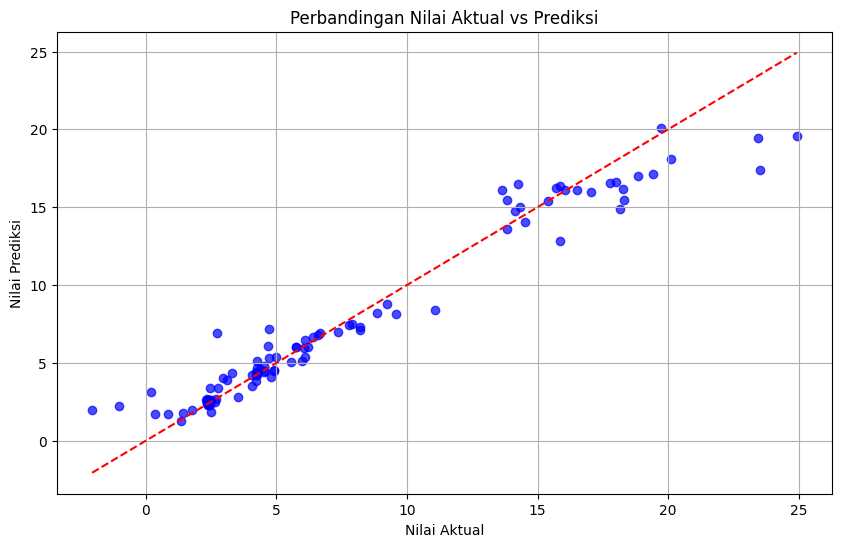

In [43]:
import matplotlib.pyplot as plt

# Plot nilai aktual vs prediksi
plt.figure(figsize=(10, 6))
plt.scatter(y_test, final_test_predictions, alpha=0.7, color="blue")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.title("Perbandingan Nilai Aktual vs Prediksi")
plt.xlabel("Nilai Aktual")
plt.ylabel("Nilai Prediksi")
plt.grid()
plt.show()

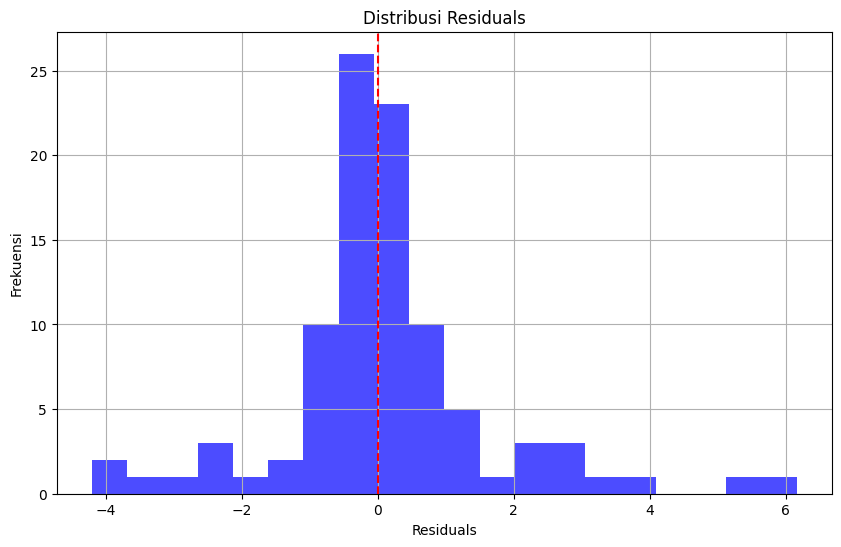

In [44]:
# Plot histogram residuals
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=20, color='blue', alpha=0.7)
plt.axvline(x=0, color='red', linestyle='--')
plt.title("Distribusi Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frekuensi")
plt.grid()
plt.show()

In [45]:
print(f"Len nama_produk: {len(test_data_processed['nama_produk'])}")
print(f"Len Nilai Aktual (y_test): {len(y_test)}")
print(f"Len Nilai Prediksi: {len(final_test_predictions)}")

Len nama_produk: 95
Len Nilai Aktual (y_test): 95
Len Nilai Prediksi: 95


In [46]:
# Pastikan indeks konsisten
test_data_processed = test_data_processed.reset_index(drop=True)
aligned_test_data = X_test_raw.reset_index(drop=True)

# Buat DataFrame perbandingan
comparison_df = pd.DataFrame({
    'Nama Produk': aligned_test_data['nama_produk'],
    'Nilai Aktual': y_test.reset_index(drop=True),
    'Nilai Prediksi': final_test_predictions
})
print(comparison_df.head(10))

                                         Nama Produk  Nilai Aktual  \
0         Cedea_FrozenFood_PremiumSalmonSausage_390G      2.744161   
1             Cedea_FrozenFood_KoreanOdengSpicy_480G      3.298083   
2         SoGood_FrozenFood_ChickenStickPremium_400G      2.451057   
3            Lotte_Biscuit_ChocoPieMarsmallow2'S_52G      4.238304   
4                  Guribee_Snack_SnackRumputLaut_65G      7.885714   
5       Roma_Bicuit_CrackersMalkistKelapaKopyor_125G      2.457143   
6  DuaKelinci_Snack_TatoTatoFrenchFriesFlameBeef_60G      5.995996   
7                SariRoti_Roti_RotiManisChocoBun_55G      6.403653   
8           ChitatoLite_Snack_PotatoAburiSeaweed_65G      4.244985   
9                   Cedea_FrozenFood_CrabStick_1000G      1.349443   

   Nilai Prediksi  
0        3.383176  
1        4.333794  
2        3.395020  
3        4.657862  
4        7.515630  
5        2.603513  
6        5.117868  
7        6.663839  
8        5.101078  
9        1.269840  
